In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [16]:
df = pd.read_pickle("Data_allnum.pkl")

In [17]:
df

,City,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
0,Los Angeles,1,0,0,0,2,1,0,1,1,...,0,0,1,1,1,53.85,108.15,1,86,3239
1,Friant,0,0,0,0,10,1,1,0,0,...,1,1,1,1,2,98.50,1058.25,1,74,5184
2,Kerman,1,0,0,0,6,1,0,0,0,...,1,0,1,1,2,85.35,489.45,1,75,4694
3,Orosi,0,0,0,0,2,1,0,0,0,...,0,1,1,1,1,86.20,178.70,1,95,2969
4,Fresno,1,0,1,0,21,1,1,0,0,...,1,1,1,1,2,111.20,2317.10,1,89,4123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Landers,0,0,0,0,72,1,0,0,0,...,0,0,2,1,4,21.15,1419.40,0,45,5306
7039,Adelanto,1,0,1,1,24,1,1,1,1,...,1,1,3,1,1,84.80,1990.50,0,59,2140
7040,Amboy,0,0,1,1,72,1,1,0,0,...,1,1,3,1,3,103.20,7362.90,0,71,5560
7041,Angelus Oaks,0,0,1,1,11,0,0,1,1,...,0,0,1,1,2,29.60,346.45,0,59,2793


### Początkowe zestawienia

Zaczniemy od spojrzenia na dane przed przeprowadzeniem na nich działań. Pierwszym krokiem jest sprawdzenie, w których miastach jest największa ilość odejść klientów

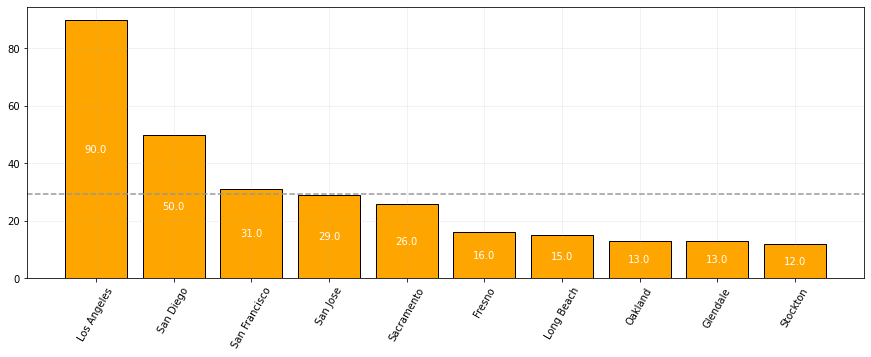

In [3]:
city_churn = df.groupby('City')['Churn Value'].agg(['sum', 'size'])
city_churn = city_churn[city_churn != 0].sort_values(by='sum', ascending=False)

X = city_churn.head(10).index
y = city_churn['sum'].head(10).values

plt.figure(figsize=(15,5))
slupki = plt.bar(np.arange(0, 10), y, color='orange', edgecolor="black")
plt.xticks(np.arange(0, 10), X, rotation=60)
plt.axhline(np.mean(y), ls='--', color='#999999')
plt.grid(alpha=0.2)

plt.bar_label(slupki, y, label_type='center', color="#ffffff")

plt.show()

Na wykresie zostało pokazane 10 miast z największą ilością odejść klientów. Aby lepiej zrozumieć dane dostawimy do nich sume ilości badanych osób w miastach oraz stosunek badań do odejść. Dzięki temu będzimy mogli zobaczyć, w którym mieście jest największy stosunek odejść klientów.

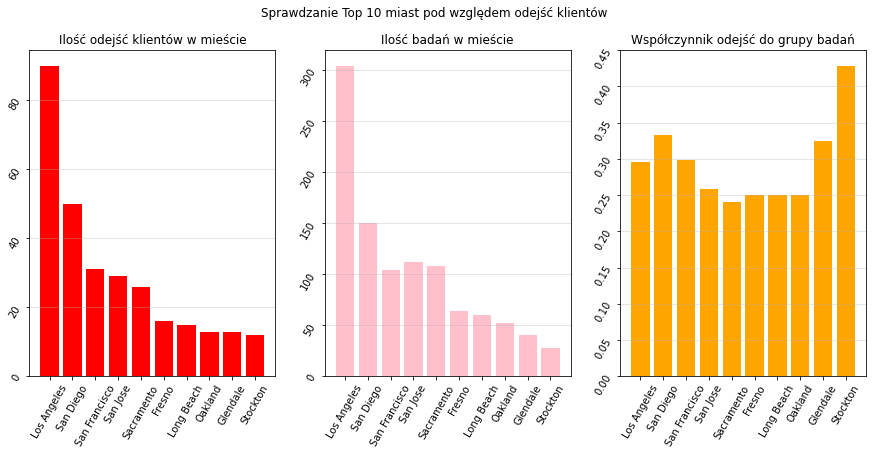

In [4]:
city_churn['comp'] = city_churn['sum'] / city_churn['size']
city_churn = city_churn[city_churn != 0].sort_values(by='sum', ascending=False)
y_churn = city_churn['sum'].head(10).values
y_size = city_churn['size'].head(10).values
y_comp = city_churn['comp'].head(10).values

fig, ax = plt.subplots(1, 3, figsize=(15,6))

ax[0].bar(X, y_churn, color="red")
ax[0].set_title("Ilość odejść klientów w mieście")

ax[1].bar(X, y_size, color="pink")
ax[1].set_title("Ilość badań w mieście")

ax[2].bar(X, y_comp, color="orange")
ax[2].set_title("Współczynnik odejść do grupy badań")

for bar in ax:
    bar.tick_params(labelrotation=60)
    bar.grid(True, axis="y", alpha=0.4)
    
fig.suptitle("Sprawdzanie Top 10 miast pod względem odejść klientów")

plt.show()

Możemy zobaczyć, że `Stockton` ma nawiększą ilość odejść w stosunku do badanych danych. Można również spojrzeć na `San Diego`, 
ma on o wiele większą ilość danych oraz drugi z kolei współczynnik odejść.

### Hierarchical clustering
Grupowanie w clustry 20 miast z nawiększą ilością odejść

In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram

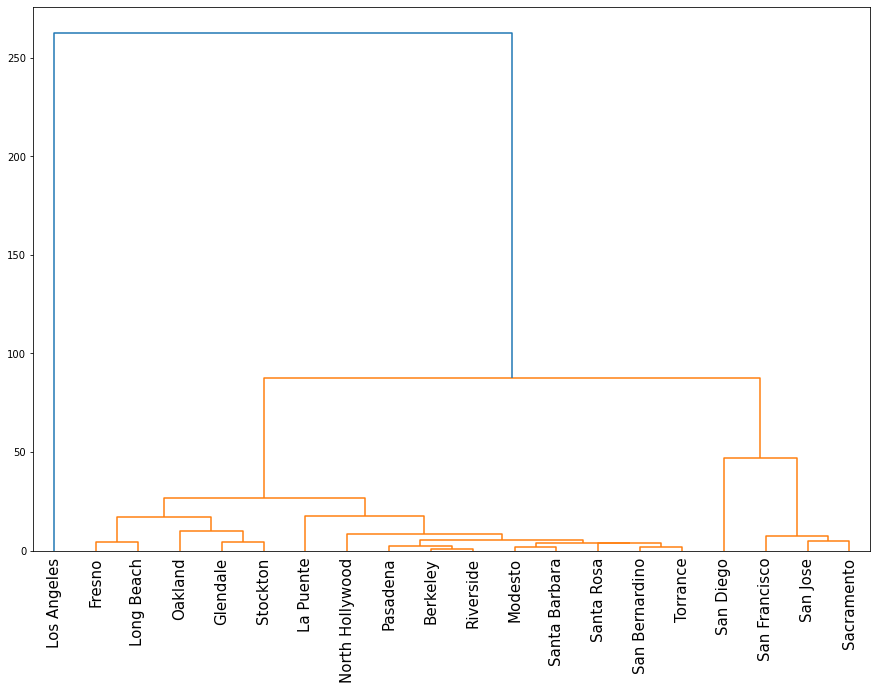

In [73]:
values = city_churn.sort_values(by='sum', ascending=False)
city_name = values.index[0:20]
values.index = range(1, len(values) + 1)
values = values[0:20]
#values = values.drop(['comp', 'sum'], axis=1)

plt.rcParams["figure.figsize"] = (15, 10)

mergings = linkage(values, method='average')
dendrogram(mergings,
          labels = city_name,
          leaf_rotation=90,
          leaf_font_size=15)
plt.show()

Możemy zobaczyć że Los Angeles jest tak duże, że tworzy osobny klaster i zaburza inne wyniki. Aby wizualizacja była bardziej przejrzysta zostanie on usunięty.

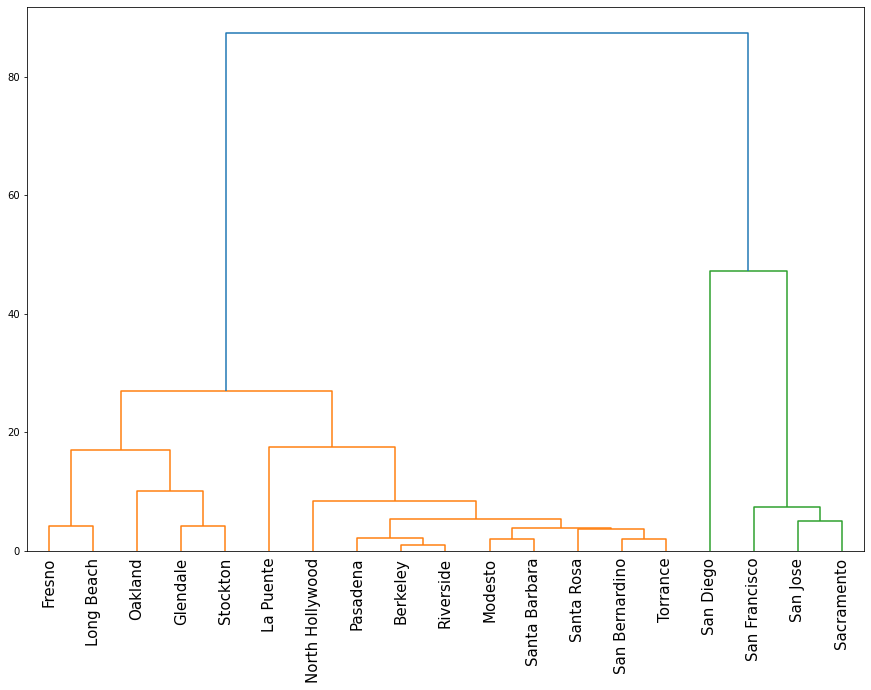

In [74]:
city_name = city_name.drop('Los Angeles')
values = values[1:20]

plt.rcParams["figure.figsize"] = (15, 10)

mergings = linkage(values, method='average')
dendrogram(mergings,
          labels = city_name,
          leaf_rotation=90,
          leaf_font_size=15)
plt.show()

Tutaj możemy zobaczyć że wyróżniają nam się już dwa klastry. Jeden z nich zawiera zdecydowanie więcej miast. Jeśli porównamy te wyniki z poprzednimi wizualizacjami możemy zobaczyć, że grupa zielona to miasta, które mają więszką ilość obeserwacji oraz większą największą liczbę odejść klientów. Firma może użyć tych grup aby wyciągnąć informacje na temat miast, które są krytyczne pod względem odejść klientów. 

In [65]:
from scipy.cluster.hierarchy import fcluster

In [84]:
labels = fcluster(mergings, t=50, criterion='distance')
city_clusters = pd.DataFrame({'City': city_name, 'Cluster' : labels}, index=range(1, len(labels) + 1))
city_clusters

,City,Cluster
1,San Diego,2
2,San Francisco,2
3,San Jose,2
4,Sacramento,2
5,Fresno,1
6,Long Beach,1
7,Oakland,1
8,Glendale,1
9,Stockton,1
10,Modesto,1


Powyżej można jeszcze zobaczyć w tabelce, które miasto przynależy do którego klastra. Funkcją fcluster w zalezności od potrzeby możemy wyciągnąć więcej klas w zależności od tego jaki dystans pomiędzy klastrami `t` jest nam odpowiadający

### Podział na zbiory

Aby dokładniej przeewaluować model zbiór zostanie podzielony na uczący i testowy w stosunku 80:20

In [5]:
X = df.drop(['City', 'Churn Value', 'Churn Score', 'CLTV'], axis=1).values
y = df['Churn Value'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Regresja logistyczna

Modele zostaną zbudowane za pomocą `pipeline`, który pozwala łączyć kilka czynności w jedną całość. W pierwszej kolejności zostanie użyta regresja logistyczna, która jest praktycznie stworzona dla problemów klasyfikacyjnych. Zostanie użyta na danych po skalowaniu oraz jej wartości zostaną zoptymalizowane za pomocą `GridSearchCV`. Do schowania powiadomień o błędnym dopasowaniu parametrów przy GridSearchCV użyty zostanie modół `warnings`, którego uzywa `sklearn` do pokazywania ostrzeżeń

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import warnings

In [7]:
logreg = LogisticRegression()

param_grid = {"solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             "penalty": ['l1', 'l2', 'elasticnet', 'none'],
             "C": [0.2, 0.5, 1, 2, 3, 5]}

warnings.filterwarnings('ignore')
cv = GridSearchCV(logreg, param_grid=param_grid, cv=5)
cv.fit(X_train, y_train)

logreg.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print(f"Najlepsze parametry regresji: {cv.best_params_}")
print(f"Najlepsze accuracy regresji: {cv.best_score_}")
print(f"Predykcja z najlepszego modelu {cv.score(X_test, y_test)} \n")

print(f"Predykcja na niedostosowanym modelu Logistic Regression {logreg.score(X_test, y_test)}")

print(classification_report(y_test, y_pred, target_names=["0", "1"]))

y_pred_proba_logreg = cv.predict_proba(X_test)[:,1]
fprlog, tprlog, thresholdlog = roc_curve(y_test, y_pred_proba_logreg)

Najlepsze parametry regresji: {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'}
Najlepsze accuracy regresji: 0.8090666666666667
Predykcja z najlepszego modelu 0.8059701492537313 

Predykcja na niedostosowanym modelu Logistic Regression 0.8038379530916845
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1024
           1       0.68      0.55      0.61       383

    accuracy                           0.81      1407
   macro avg       0.76      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407



W tym przykładzie dostosowanie parametrów nie wprowadziło istotnej różnicy i proces jest lepszy o około 0,05pp. Natomiast model osiągnął dokładność na poziomie 80%

### Drzewo decyzyjne

Kolejnym modelem, który zostanie wybrany do testowania predykcji danych jest `Decision Tree`. Tak jak w poprzednim modelu za pomocą `GridSearchCV` zostaną dostosowane parametry modelu. W modelu nie zostanie wykonane skalowanie ponieważ nie jest on wrażliwy na wariancje.

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [9]:
tree = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy'],
             'max_depth': [2, 3, 5, 7, 10],
             'min_samples_split': [4, 6, 8, 12, 15],
             'min_samples_leaf': [3, 4, 5, 8, 10]}
cv = GridSearchCV(tree, param_grid=param_grid, cv=5)

warnings.filterwarnings('ignore')
cv.fit(X_train, y_train)
tree.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print(f"Najlepsze parametry regresji: {cv.best_params_}")
print(f"Najlepsze accuracy regresji: {cv.best_score_}")
print(f"Predykcja z najlepszego modelu {cv.score(X_test, y_test)} \n")

print(f"Predykcja na niedostosowanym modelu drzewa decyzyjnego {tree.score(X_test, y_test)}")

print("Raport z klasyfikacji dla modelu \n")
print(classification_report(y_test, y_pred, target_names=["0", "1"]))

y_pred_proba_tree = cv.predict_proba(X_test)[:,1]
fprtree, tprtree, thresholdtree = roc_curve(y_test, y_pred_proba_tree)

Najlepsze parametry regresji: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 4}
Najlepsze accuracy regresji: 0.7896888888888889
Predykcja z najlepszego modelu 0.7874911158493249 

Predykcja na niedostosowanym modelu drzewa decyzyjnego 0.7185501066098081
Raport z klasyfikacji dla modelu 

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1024
           1       0.61      0.61      0.61       383

    accuracy                           0.79      1407
   macro avg       0.73      0.73      0.73      1407
weighted avg       0.79      0.79      0.79      1407



### KNN
Ostatnim modelem, który przerobimy jest KNN z dostosowaniem parametrów i skalowaniem wartości w pipeline.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 

In [11]:
knn = KNeighborsClassifier()
scaler = StandardScaler()

steps = [("scaler", scaler),
         ("knn", knn)]
pipeline = Pipeline(steps)

param_grid = {"knn__n_neighbors": [4, 6, 8, 12, 20],
             "knn__algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
             "knn__leaf_size": [30, 35, 40, 50]}
cv = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
cv.fit(X_train, y_train)

knn.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print(f"Najlepsze parametry regresji: {cv.best_params_}")
print(f"Najlepsze accuracy regresji: {cv.best_score_}")
print(f"Predykcja z najlepszego modelu {cv.score(X_test, y_test)} \n")

print(f"Predykcja na niedostosowanym modelu K-nearest neighbors: {knn.score(X_test, y_test)}")

print(classification_report(y_test, y_pred, target_names=["0", "1"]))

y_pred_proba_knn = cv.predict_proba(X_test)[:,1]
fprknn, tprknn, thresholdtree = roc_curve(y_test, y_pred_proba_knn)

Najlepsze parametry regresji: {'knn__algorithm': 'ball_tree', 'knn__leaf_size': 30, 'knn__n_neighbors': 12}
Najlepsze accuracy regresji: 0.7888000000000002
Predykcja z najlepszego modelu 0.8002842928216063 

Predykcja na niedostosowanym modelu K-nearest neighbors: 0.759772565742715
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1024
           1       0.67      0.52      0.59       383

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407



### Krzywe ROC i AUC modeli

In [12]:
from sklearn.metrics import roc_auc_score

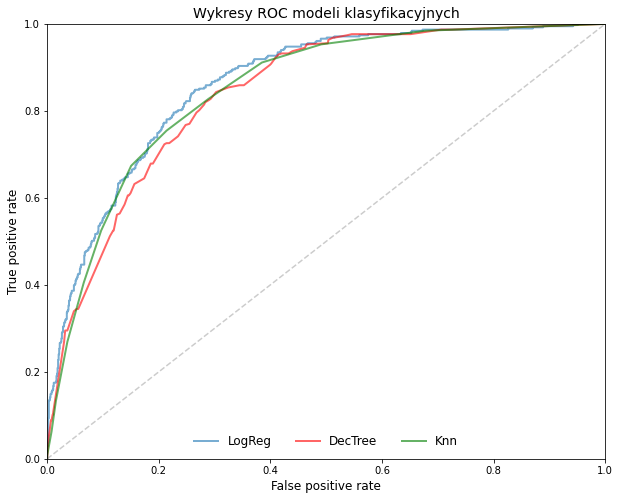

LogReg AUC: 	 0.8622842893276762
Tree AUC: 	 0.841693609252611
Knn AUC:	 0.8494053932767625


In [13]:
plt.figure(figsize=(10,8))

plt.plot(fprlog, tprlog, label="LogReg", lw=2, alpha=0.6)
plt.plot(fprtree,tprtree, label="DecTree", color="red", lw=2, alpha=0.6)
plt.plot(fprknn, tprknn, label="Knn", color="green", lw=2, alpha=0.6)

plt.legend(frameon=False, loc=8, ncol=3, fontsize=12)


plt.axline((0,0), (1,1), color='gray', alpha=0.4, ls='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.title("Wykresy ROC modeli klasyfikacyjnych", fontsize=14)

plt.show()

print(f'LogReg AUC: \t {roc_auc_score(y_test, y_pred_proba_logreg)}')
print(f'Tree AUC: \t {roc_auc_score(y_test, y_pred_proba_tree)}')
print(f'Knn AUC:\t {roc_auc_score(y_test, y_pred_proba_knn)}')